In [67]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from datetime import datetime

In [58]:
df = pd.read_csv('data/southern_osc.zip',  index_col=['Date'], parse_dates=['Date'])
df.index.freq = 'MS'
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 822 entries, 1951-01-01 to 2019-06-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T_i     822 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


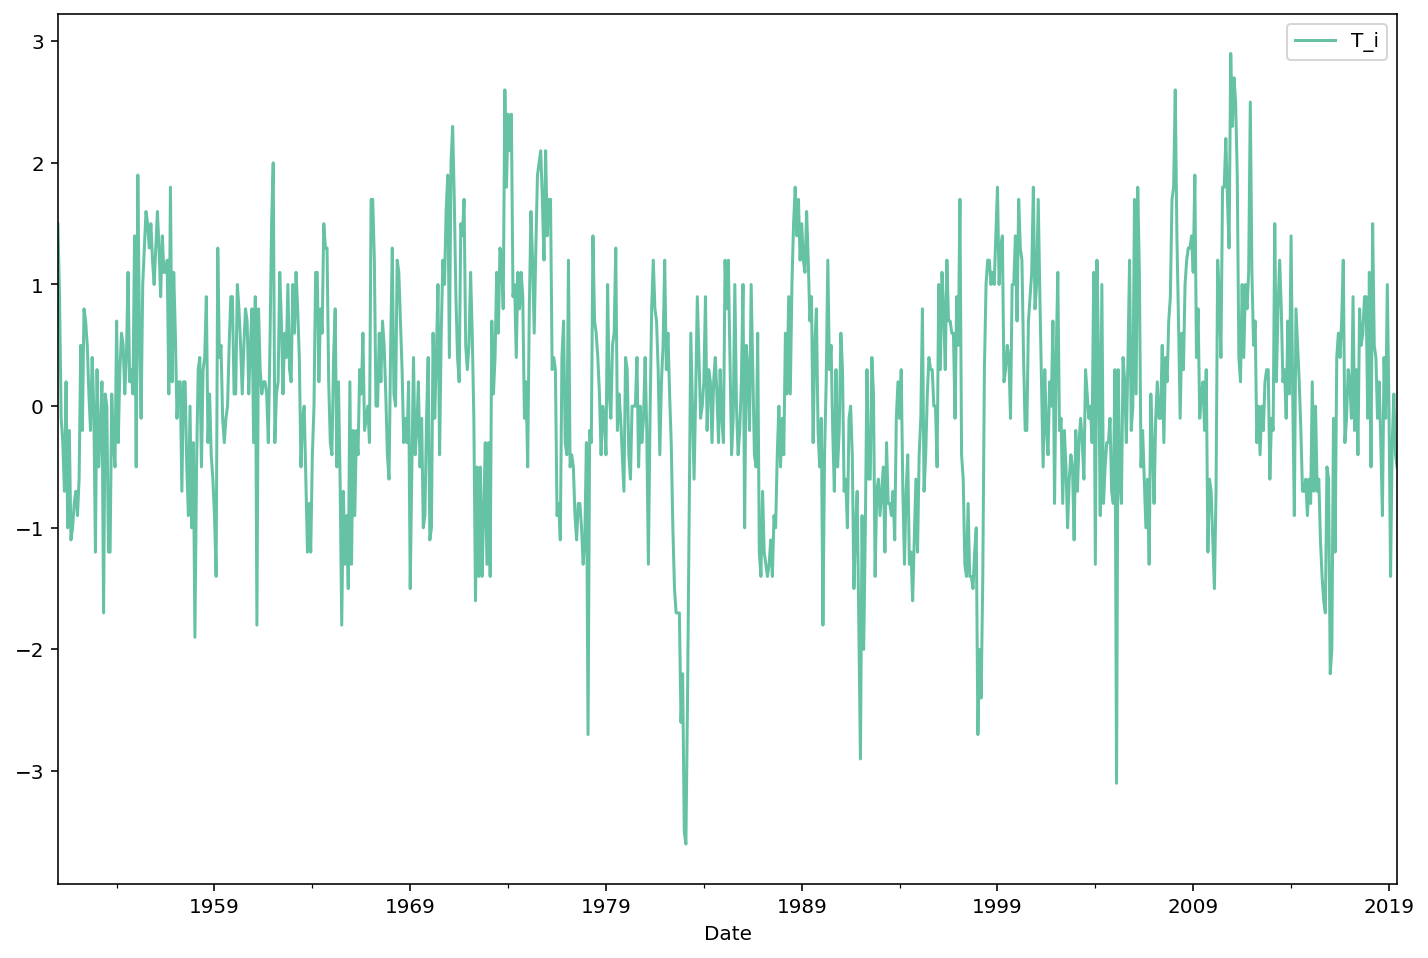

In [59]:
df.plot();

### Производим декомпозицию временного ряда на составляющие

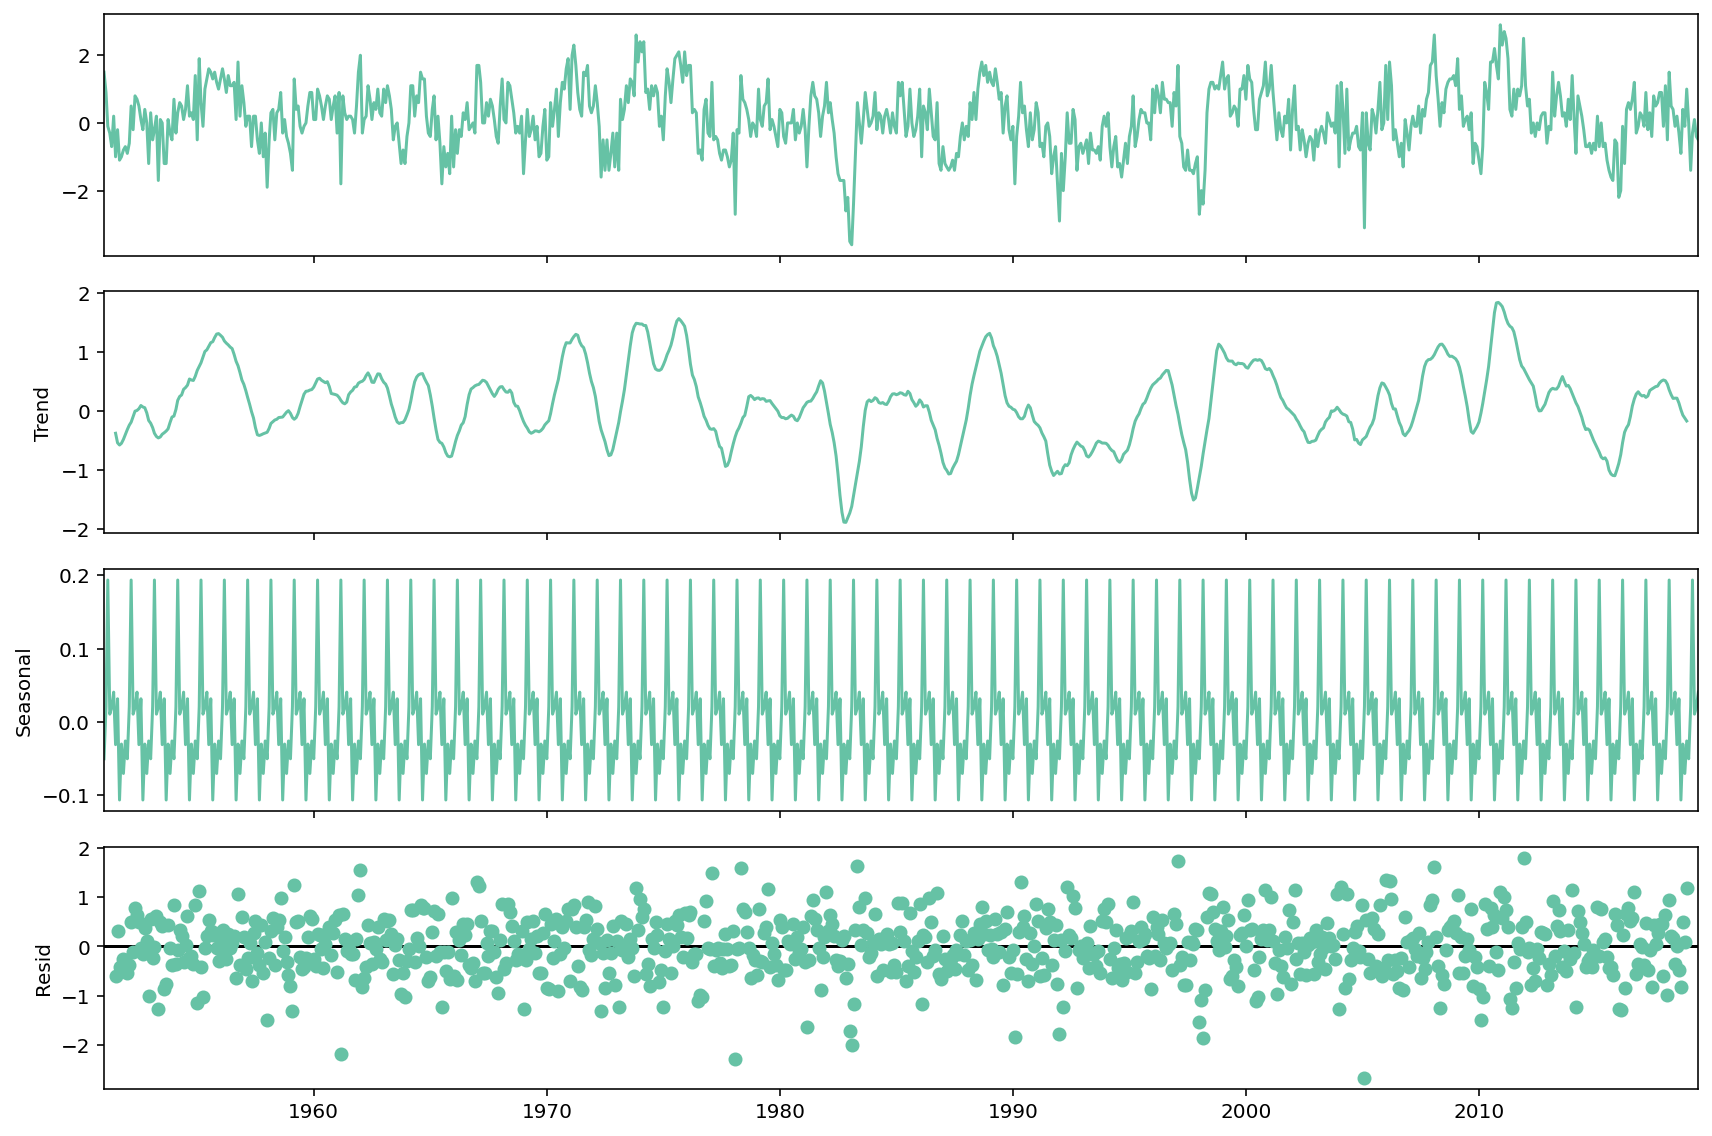

In [60]:
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show() # любуемся результатом

Для тренировочной выборки используем все данные кроме последнего месяца

In [61]:
train_df = df.iloc[:-1]
test_df = df.iloc[-1]

In [62]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp_pred

2019-06-01   -0.302693
Freq: MS, dtype: float64

In [65]:
exp_pred.iloc[0]

-0.3026933056816984

### Проверка временного ряда на стационарность

In [68]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  -7.790397600107422
p-value:  7.970501826429107e-12
Critical values:  {'1%': -3.438369485934381, '5%': -2.865079774912655, '10%': -2.5686548826226527}
единичных корней нет, ряд стационарен


In [69]:
hd.adf(df)

Test-Statistic: -7.787181201947423
P-Value: 8.12095887574495e-12
Time series is stationary!


Т.к. ряд стационарен, то дифференцирование не нужно

In [48]:
#otg1diff = df.diff(periods=1).dropna()

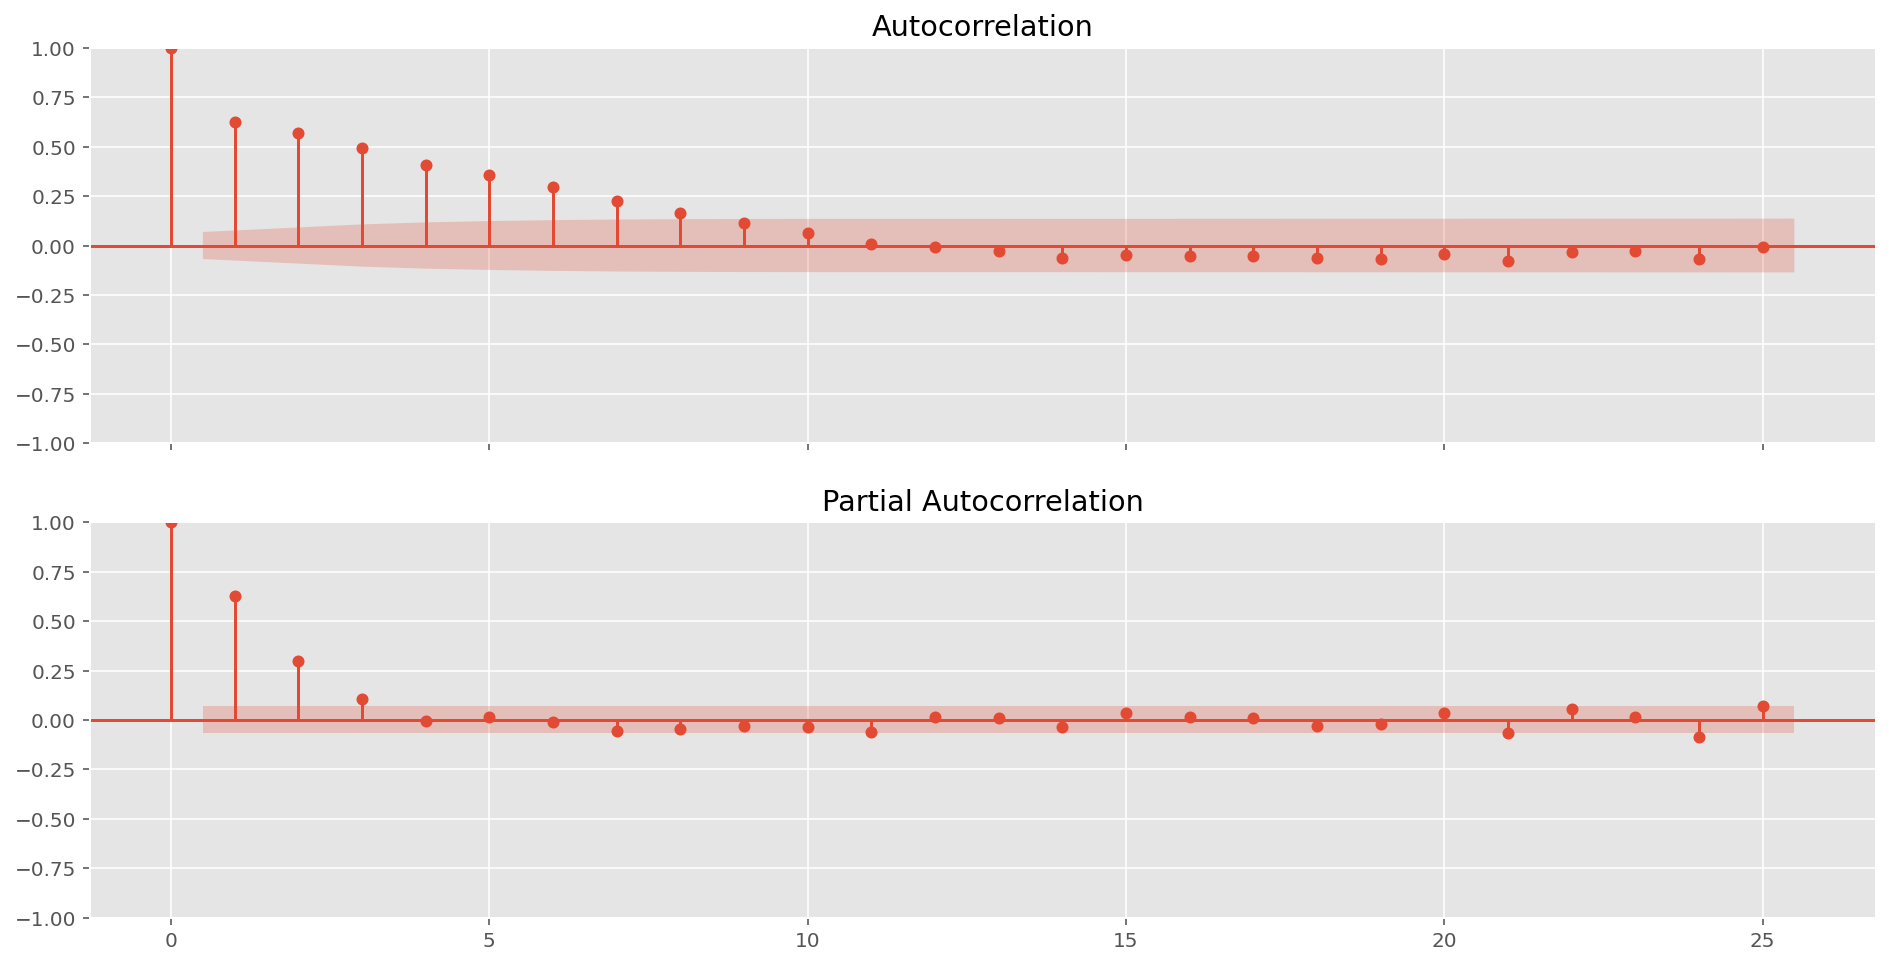

In [80]:
lags = 25
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

sm.graphics.tsa.plot_acf(train_df.values.squeeze(), lags=lags, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_df, lags=lags, ax=ax[1])
plt.show()

По графику частичной автокорреляции выбрию последний значимый лаг за пределами доверительного интервала.

Это 2, а может и 3, он уже совсем близок к границе доверительного интервала и мал.

In [87]:
p = 2

In [88]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train_df, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    T_i   No. Observations:                  821
Model:                     AutoReg(2)   Log Likelihood                -868.728
Method:               Conditional MLE   S.D. of innovations              0.699
Date:                Wed, 26 Jul 2023   AIC                           1745.455
Time:                        13:21:09   BIC                           1764.288
Sample:                    03-01-1951   HQIC                          1752.682
                         - 05-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0308      0.025      1.247      0.212      -0.018       0.079
T_i.L1         0.4405      0.033     13.194      0.000       0.375       0.506
T_i.L2         0.2961      0.033      8.881      0.0

2019-06-01   -0.11579
Freq: MS, dtype: float64

In [90]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_df, exp_pred), mean_squared_error(test_df, ar_pred)

(0.03892993162281572, 0.1476173477399788)

In [91]:
p = 3
ar_model = AutoReg(train_df, lags=p).fit()
ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)
ar_pred

2019-06-01   -0.141288
Freq: MS, dtype: float64

In [92]:
mean_squared_error(test_df, ar_pred)

0.1286744582955466

Получается что для p=3 MSE меньше чем для p=2, но все-равно в данном кейсе экспоненциальное сглаживание показывает лучший результат.